# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [53]:
# Load pickled data
# Pickle is used to serialize the data so that it can be saved to a disk
import pickle

training_file = './data/train.p'
validation_file = './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

#Each pickled dataset is a dictionary of 4 keys
#dict_keys(['sizes', 'labels', 'features', 'coords'])
print(train.keys())

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

dict_keys(['features', 'coords', 'sizes', 'labels'])


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [54]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
from sklearn.utils import shuffle
import matplotlib.pyplot as plt



#Number of labels should be same as number of input images
assert(len(X_train) == len(y_train))
n_train = len(X_train)

assert(len(X_valid) == len(y_valid))
n_valid = len(X_valid)

assert(len(X_test) == len(y_test))
n_test = len(X_test)

# Image Shape
image_shape = X_train[0].shape

# Number of classes / labels
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

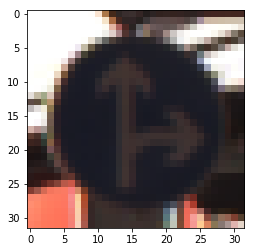

Speed limit (20km/h) :: 180
Speed limit (30km/h) :: 1980
Speed limit (50km/h) :: 2010
Speed limit (60km/h) :: 1260
Speed limit (70km/h) :: 1770
Speed limit (80km/h) :: 1650
End of speed limit (80km/h) :: 360
Speed limit (100km/h) :: 1290
Speed limit (120km/h) :: 1260
No passing :: 1320
No passing for vehicles over 3.5 metric tons :: 1800
Right-of-way at the next intersection :: 1170
Priority road :: 1890
Yield :: 1920
Stop :: 690
No vehicles :: 540
Vehicles over 3.5 metric tons prohibited :: 360
No entry :: 990
General caution :: 1080
Dangerous curve to the left :: 180
Dangerous curve to the right :: 300
Double curve :: 270
Bumpy road :: 330
Slippery road :: 450
Road narrows on the right :: 240
Road work :: 1350
Traffic signals :: 540
Pedestrians :: 210
Children crossing :: 480
Bicycles crossing :: 240
Beware of ice/snow :: 390
Wild animals crossing :: 690
End of all speed and passing limits :: 210
Turn right ahead :: 599
Turn left ahead :: 360
Ahead only :: 1080
Go straight or right :

In [55]:
def readcsv(file):
    with open(file) as csvfile:
        reader = csv.DictReader(csvfile)
        label_dict = {row['ClassId']:row['SignName'] for row in reader}
        return label_dict

# Visualizations will be shown in the notebook using this command
%matplotlib inline
plt.imshow(X_train[1199])
plt.show()

#Number of occurances of types of images in training set
count, label = np.unique(y_train, return_counts=True)
label_dict = readcsv('signnames.csv')
for i, j in zip(count, label):
    print('{} :: {}'.format(label_dict[repr(i)], j))

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

#### Shuffling, Normalizing
Images in Training set are in order, so to get better results and prevent overfitting, shuffle the dataset
Shuffling should be done for both Images & labels in sync.
To ensure, check the label count post shuffling

Laels before Shuffling [41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41]
Laels after Shuffling [40 38 12 10 26 28 13 18 12 41 35 35 11  3 38  4  8  4 12  3 11 38 25  7 13]

Labels vs Count to ensure this pair doesn't change post shuffling

Speed limit (20km/h) :: 180
Speed limit (30km/h) :: 1980
Speed limit (50km/h) :: 2010
Speed limit (60km/h) :: 1260
Speed limit (70km/h) :: 1770
Speed limit (80km/h) :: 1650
End of speed limit (80km/h) :: 360
Speed limit (100km/h) :: 1290
Speed limit (120km/h) :: 1260
No passing :: 1320
No passing for vehicles over 3.5 metric tons :: 1800
Right-of-way at the next intersection :: 1170
Priority road :: 1890
Yield :: 1920
Stop :: 690
No vehicles :: 540
Vehicles over 3.5 metric tons prohibited :: 360
No entry :: 990
General caution :: 1080
Dangerous curve to the left :: 180
Dangerous curve to the right :: 300
Double curve :: 270
Bumpy road :: 330
Slippery road :: 450
Road narrows on the right :: 240
Road work :: 1350
Traffic sig

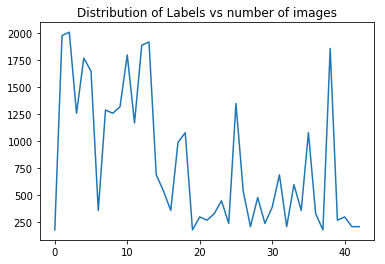

In [56]:
#Images are in order, so shuffle them
print('Laels before Shuffling', y_train[:25])

X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)
print('Laels after Shuffling', y_train_shuffle[:25])

#To check if the count has changed after shuffling, which ideally shouldn't
count, label = np.unique(y_train_shuffle, return_counts=True)
label_dict_shuffle = readcsv('signnames.csv')
print('\nLabels vs Count to ensure this pair doesn\'t change post shuffling\n')
count_var = []
for i, j in zip(count, label):
    print('{} :: {}'.format(label_dict_shuffle[repr(i)], j))
    count_var.append(j)

plt.plot(count_var)
plt.title('Distribution of Labels vs number of images')

#### Normalize Inputs
It is a good practice to normalize the data to have a zero mean so that the process of gradient descent will be faster
Normalization chagnes the magnitude of the values of the data, but doesn't chagne the content of the data. Printing the before/after image will ensure this

Orignal Shape of the Image (32, 32, 3) 
Shape after normalization (32, 32, 3)
Original Mean 82.6775890369964 
Normalized Mean -0.17577416063923074


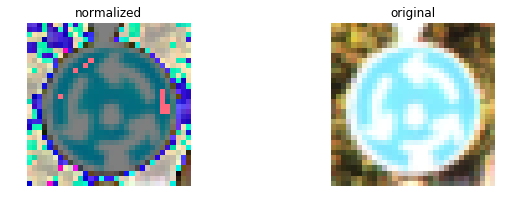

In [57]:
X_train_shuffle_normalized = (X_train_shuffle - 127.5) / 255

#Assigning back to original input variables after pre-processing
X_train, y_train = X_train_shuffle_normalized, y_train_shuffle

#No change in shape due to normalization
print('Orignal Shape of the Image {} \nShape after normalization {}'.format(X_train[0].shape,X_train_shuffle_normalized[0].shape))

#Mean value after normalization
X_train_shuffle_mean = np.mean(X_train_shuffle_normalized)

print('Original Mean {} \nNormalized Mean {}'.format(np.mean(X_train_shuffle), X_train_shuffle_mean))

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
#CHK
#axs = axs.ravel()

#axis off won't display the grid along x,y axis
#TODO - Loop through and display 10 images
axs[0].axis('off')
axs[0].set_title('normalized')
axs[0].imshow(X_train_shuffle_normalized[0].squeeze(), cmap='gray')

axs[1].axis('off')
axs[1].set_title('original')
axs[1].imshow(X_train_shuffle[0].squeeze(), cmap='gray')

### Neural Network Model
This is based on LeNet Architecture by Yann LeCunn

In [58]:
#Define variables
inputs = tf.placeholder(tf.float32, [None, image_shape[1], image_shape[0], image_shape[2]])

weights = tf.Variable(tf.truncated_normal([filter_height, filter_width, filter_depth, n_classes]))
bias = tf.Variable(tf.zeros(n_classes))

stride = [1, 2, 2, 1]
padding = [1, 2, 2, 1]

# Conv --> MaxPool --> Conv --> MaxPool --> FC1 --> FC2 --> o/p
def NN_LeNet(inputs):
    """
    LeNet Architecture
    CN1 --> P1 --> CN2 --> P2 --> Flatten --> FC1 --> FC2 --> O/P
    Each step after CN & FC follows by an activation layer
    Here are the dimensions of LeNet

    Input : 32, 32, 3 #3 channels for RGB. If you are using Gray scale, then have this as 1
    Layer1 : CN1 Output : 28, 28, 6
    Layer2 : P1 Output  : 14, 14, 6
    Layer3 : CN2 Output : 10, 10, 16
    Layer4 : P2 Output  : 5, 5, 16
    Layer5 : FC1 Output : 120
    Layer6 : FC2 Output : 84
    Layer7 : Logits     : 41 #41 different classes in German Traffic Sign dataset
    """

    #Defining weights, bias and outputs for each Layer
    mu = 0 #Mean of the variables in the random distribution
    sigma = 0.1 #Variance is 0.1
    
    #Layer1 - Convolution - Output Size : 28, 28, 6
    w_layer1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean=mu, stddev=sigma))
    b_layer1 = tf.Variable(tf.zeros(6))
    conv_layer1 = tf.nn.conv2d(inputs, w_layer1, strides=[1,1,1,1], padding='VALID') + b_layer1
    act_layer1 = tf.nn.relu(conv_layer1)

    #Layer2 - Max Pooling - Output Size : 14, 14, 6
    pool_layer2 = tf.nn.max_pool(act_layer1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Layer3 - Convolution - Output Size : 10, 10, 16 ==> 16 filters, size is (W + 2P - F)/S + 1
    w_layer3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    b_layer3 = tf.Variable(tf.zeros(16))
    conv_layer3 = tf.nn.conv2d(pool_layer2, w_layer3, strides=[1, 1, 1, 1], padding='VALID') + b_layer3
    act_layer3 = tf.nn.relu(conv_layer3)

    #Layer4 - Max Pooling - Output Size : 5, 5, 16
    pool_layer4 = tf.nn.max_pool(act_layer3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Flatenning as next layers are fully connected
    flatten_vect = tf.contrib.layers.flatten(pool_layer4)

    #Layer5 - Fully Connected - Output = 120. Input dimension would be 5*5*16 = 400
    w_layer5 = tf.Variable(tf.random_normal(shape=(400, 120), mean=mu, stddev=sigma))
    b_layer5 = tf.Variable(tf.zeros(120))
    fc_layer5 = tf.matmul(flatten_vect, w_layer5) + b_layer5
    act_layer5 = tf.nn.relu(fc_layer5)

    #Layer6 - Fully Connected - Output = 84. Input dimension is 120
    w_layer6 = tf.Variable(tf.random_normal(shape=(120, 84), mean=mu, stddev=sigma))
    b_layer6 = tf.Variable(tf.zeros(84))
    fc_layer6 = tf.matmul(act_layer5, w_layer6) + b_layer6
    act_layer6 = tf.nn.relu(fc_layer6)

    #Layer7 - Logits - Output Size : 41 types of image classes in the input dataset
    w_layer7 = tf.Variable(tf.random_normal(shape=(84, 41), mean=mu, stddev=sigma))
    b_layer7 = tf.Variable(tf.zeros(41))
    logits = tf.matmul(act_layer6, w_layer7) + b_layer7
    
    return logits

### Defining Input Variables
This is for storing the individual batch features & labels
The inputs will be fed at runtime from the batches made out of training data set

Batchsize is None so that it can accept a batch of anysize later at runtime

In [59]:
#None is a placeholder which depends on the number of input images in the batch (k)
#Observe that input data will be float, but labels will always be integers. Otherwise one hot doesn't work
input_data = tf.placeholder(tf.float32, (None, 32, 32, 3))
input_labels = tf.placeholder(tf.int32, (None))
one_hot_labels = tf.one_hot(input_labels, 41)

### Training Pipeline
In this pipeline, we train the model by calculating the following
Logits are calculated using the Neural Network
Cross Entropy loss is the difference between the logits vector and ground truth(in the form of one hot encoded vector)
Average over cross entropy of all the training images (of this batch)
Minimize the loss using Adam Optimizer
Using the loss determined, backprop and adjust weights

THis results in a pipeline that can be used for training. But data has to be fed to this pipeline so that the NN can be trained

In [60]:
learn_rate = 0.001

logits = NN_LeNet(inputs)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_labels)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learn_rate)
training_operation = optimizer.minimize(loss)

### Evaluating the Model
In this cell, we evaluate the model by comparing the output of the model to the ground truth
Correct Prediction is determined by comparing the logits output to the ground truth variables(in one-hot format)
Then Accuracy of your model is measured by calculating the model's overall accuracy by calculating the individual accuracies
Evaluate function takes complete input data, splits into batches to calculate the accuracy and finally combines it

In [61]:
BATCH_SIZE = 128


correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(x_data, y_data):
    total_accuracy = 0
    length_inputs = len(x_data)
    sess = tf.get_default_session()
    for offset in range(0, length_inputs, BATCH_SIZE):
        batch_x, batch_y = x_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        batch_accuracy = sess.run(accuracy, feed_dict={input_data:batch_x, input_labels:batch_y})
        total_accuracy += (batch_accuracy * len(batch_x))
    return total_accuracy / length_batch

### Train the Model
In this cell, we train the model
Shuffle the inputs so that your model is not dependent on the order of the inputs
Use the training_operation which is defined in the 'Training Pipeline' to do a fwd/back pass and update the weights and biases


A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [62]:
EPOCHS = 200

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_total = len(X_train)
    print('Training...')
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_total, BATCH_SIZE):
            batch_x, batch_y = X_train[offset:offset+BATCH_SIZE], y_train[offset:offset+BATCH_SIZE]
            sess.run(training_operation, feed_dict={input_data:batch_x, input_labels:batch_y})
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print('EPOCH {} --- '.format(i+1))
        print('Validation Accuracy = {.3f}'.format(validation_accuracy),'\n')
        
        try:
            saver
        except NameError:
            saver = tf.train.Saver()
        saver.save(sess, 'lenet')
        print('Model Saved')

Training...


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_22' with dtype float
	 [[Node: Placeholder_22 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Placeholder_22', defined at:
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-58-944ee3ab6bd4>", line 2, in <module>
    inputs = tf.placeholder(tf.float32, [None, image_shape[1], image_shape[0], image_shape[2]])
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1587, in placeholder
    name=name)
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 2043, in _placeholder
    name=name)
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\RSavirig\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_22' with dtype float
	 [[Node: Placeholder_22 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")